# Employment Map of Georgia by Regions

A choropleth map of employment by regions in Georgia.

In [1]:
from IPython.display import display, HTML

display(HTML("""<img alt="Map of Employment" src="map.png"></img>"""))

# Employment by Regions in Georgia

Purpose of this notebook is to create a **map of Georgia** with colors reflecting a statistic of employment by regions. For this purpose, the `coolwarm` colormap is used, so that regions with statistically less employment will appear in cooler colors on the map and the regions with statistically higher employment will appear in warmer colors. The exact meaning of each color is explained in the legend placed next to the map itself. See the resulting map in the beggining of this notebook. 

Data sources:
- Statistical data of the Labour Force Indicators by Regions of Georgia is retrieved on Jun 1, 2022 from the website of the National Statistics Office of Georgia: [geostat.ge](https://www.geostat.ge/en/)
- Map data of the borders of the administrative areas of Georgia (GADM data v4.0 for Georgia in `Shapefile` format) is retrieved on Jun 1, 2022 from the GADM website: [gadm.org](https://gadm.org)

In [2]:
from datetime import datetime, timedelta
nb_st = datetime.utcnow()
print(f"\nNotebook START time: {nb_st} UTC\n")


Notebook START time: 2022-08-14 06:13:59.213870 UTC



In [3]:
%%HTML
<style>
@media (max-width: 540px) {
  .output .output_subarea {
    max-width: 100%;
  }
}
</style>
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('🔎 Show Python Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('⌦ Hide Python Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide();
    $('div.input:contains("%%HTML")').removeClass( "input")
    $('div.input:contains("%%capture")').removeClass("input")
  });
</script>
<form action="javascript:code_toggle()">
  <input type="submit" id="toggleButton" value="🔎 Show Python Code"
         class="btn btn-default btn-lg">
</form>

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas

In [5]:
VERBOSE=False

In [6]:
DATA_FILE_PATH = "data/05-Labour-Force-Indicators-by-regions.xlsx"


def read_employment_data_of_year(
        year: int,
        target_feature: str,
        excel_path: str = DATA_FILE_PATH) -> pd.DataFrame:
    df = pd.read_excel(excel_path)
    df = df.loc[df.index >= df.loc[df.iloc[:,0] == year].index.item()]
    col_names = df.head(2).tail(1).values
    df = df.loc[df.iloc[:,0] == target_feature].head(1)
    df.columns = col_names[0]
    df = df.T.reset_index()
    df.columns = ['Region', target_feature]
    df = df.dropna()
    df = df.sort_values(by=target_feature, ascending=True)
    return df.reset_index(drop=True)

In [7]:
features_available = [
    'Total 15 + population',  # 0
    'Labour force',  # 1
    'Employed',  # 2
    'Hired',  # 3
    'Self-employed',  # 4
    'Not-identified worker',  # 5
    'Unemployed',  # 6
    'Population outside labour force',  # 7
]
year, target_feature = 2021, features_available[3]
df = read_employment_data_of_year(year, target_feature)
print(f"\nData for {year} year:\n")
display(df)


Data for 2021 year:



,Region,Hired
0,Racha-Lechkhumi and Kvemo-Svaneti,7.102363
1,Guria,17.835517
2,Mtskheta-Mtianeti,21.370056
3,Samtskhe-Javakheti,30.006213
4,Shida Kartli,51.550302
5,Kakheti,56.537744
6,Samegrelo-Zemo Svaneti,58.569218
7,Kvemo Kartli,76.423655
8,Adjara A/R,80.63719
9,Imereti,101.9573


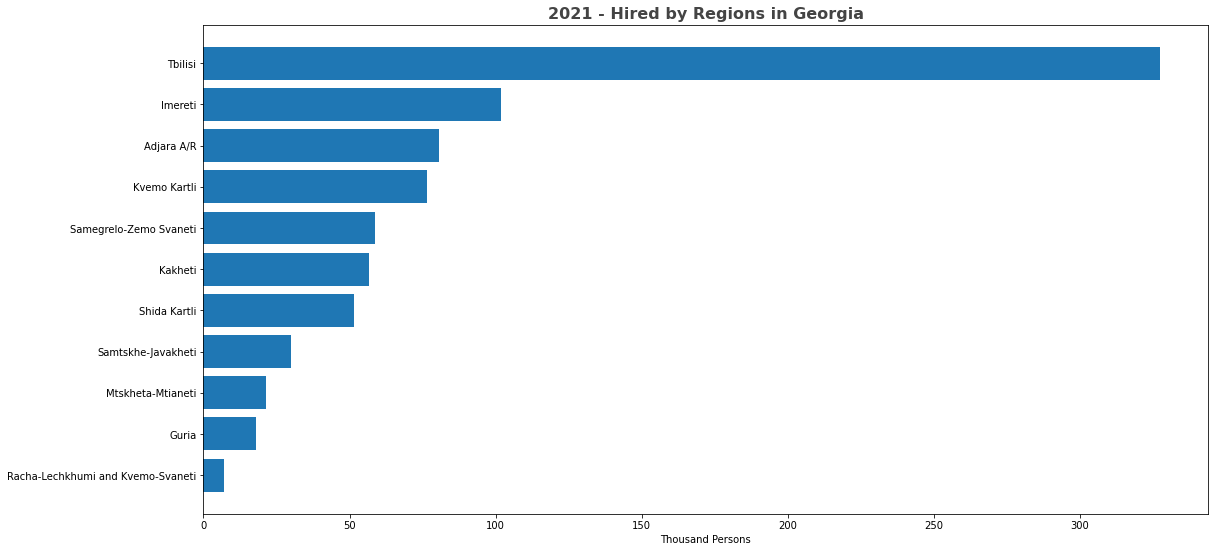

In [8]:
plt.figure(figsize=(18,9))
plt.barh(
    data=df.loc[df['Region'] !='Georgia'],
    y='Region',
    width=target_feature,
)
plt.title(f'{year} - {target_feature} by Regions in Georgia',
          fontdict={
              'fontsize': 16,
              'fontweight': 'bold',
              'color': '#444444',
              'verticalalignment': 'baseline',
              'horizontalalignment': 'center',
          })
plt.xlabel('Thousand Persons')
plt.show()

In [9]:
ADMINISTRATIVE_BORDERS_FILE_PATH = 'data/GADM/gadm40_GEO_shp/gadm40_GEO_1.shp'

Georgia_geodf = geopandas.read_file(ADMINISTRATIVE_BORDERS_FILE_PATH)

In [10]:
if VERBOSE:
    print(Georgia_geodf['NAME_1'].unique())

In [11]:
if VERBOSE:
    print('Check if there is any mismatch in region names '
          'between data and map:')
    df.set_index('Region').index.difference(Georgia_geodf['NAME_1'].unique())

In [12]:
if VERBOSE:
    print('Resolving name mismatch detected earlier '
          'in order to connect employment data to map data...')

df = df.replace(
    {
        'Adjara A/R': 'Ajaria',
        'Racha-Lechkhumi and Kvemo-Svaneti': 'Racha-Lechkhumi-Kvemo Svaneti',
    })

In [13]:
if VERBOSE:
    print('Checking if mismatch is resolved (expecting no region names):')
    df.set_index('Region').index.difference(Georgia_geodf['NAME_1'].unique())

In [14]:
merged_geodf = Georgia_geodf.merge(df,
                                   left_on='NAME_1',
                                   right_on='Region',
                                   how='left').fillna(0)

if VERBOSE:
    print("Map data with statistics for the "
          f"{len(Georgia_geodf['NAME_1'].unique())} regions of Georgia "
          "is ready.")

In [15]:
ax = merged_geodf.plot(
    column=target_feature,
    scheme="Quantiles",
    figsize=(18, 9),
    legend=True,
    legend_kwds = {"fmt": "{:.1f}", "title": "Thousand Persons"},
    cmap='coolwarm',
)
plt.gca().set_axis_off()
plt.title(f'{year} - {target_feature} by Regions in Georgia',
          fontdict={
              'fontsize': 16,
              'fontweight': 'bold',
              'color': '#444444',
              'verticalalignment': 'baseline',
              'horizontalalignment': 'center'
          })
plt.tight_layout()

##
# Instead of displaying here save the map as `map.png` image file
# in order to display in the beggining of this notebook.
# FIXME: This approach may require 2x run of notebook to update the map
##
plt.gcf().savefig("map.png")



# plt.show()


plt.close()
pass

In [16]:
print(f"\n ** Total Elapsed time: {datetime.utcnow() - nb_st} ** \n")
print(f"Notebook END time: {datetime.utcnow()} UTC\n")


 ** Total Elapsed time: 0:00:01.534320 ** 

Notebook END time: 2022-08-14 06:14:00.748248 UTC



In [17]:
%%capture
%mkdir OGP_classic

In [18]:
%%capture
%%file "OGP_classic/conf.json"
{
  "base_template": "classic",
  "preprocessors": {
    "500-metadata": {
      "type": "nbconvert.preprocessors.ClearMetadataPreprocessor",
      "enabled": true,
      "clear_notebook_metadata": true,
      "clear_cell_metadata": true
    },
    "900-files": {
      "type": "nbconvert.preprocessors.ExtractOutputPreprocessor",
      "enabled": true
    }
  }
}

In [19]:
%%capture
%%file "OGP_classic/index.html.j2"
{%- extends 'classic/index.html.j2' -%}
{%- block html_head -%}

{#  OGP attributes for shareability #}
<meta property="og:url"          content="https://sentinel-1.github.io/employment_map_Georgia/" />
<meta property="og:type"         content="article" />
<meta property="og:title"        content="Employment Map of Georgia by Regions" />
<meta property="og:description"  content="Visualized Statistics of Employment in Georgia by regions" />
<meta property="og:image"        content="https://raw.githubusercontent.com/sentinel-1/employment_map_Georgia/master/map.png" />
<meta property="og:image:alt"    content="Map of Employment" />
<meta property="og:image:type"   content="image/png" />
<meta property="og:image:width"  content="1296" />
<meta property="og:image:height" content="648" />

<meta property="article:published_time" content="2022-06-02T14:25:20+00:00" />
<meta property="article:modified_time"  content="{{ resources.iso8610_datetime_utcnow }}" />
<meta property="article:publisher"      content="https://sentinel-1.github.io" />
<meta property="article:author"         content="https://github.com/sentinel-1" />
<meta property="article:section"        content="datascience" />
<meta property="article:tag"            content="datascience" />
<meta property="article:tag"            content="geospatialdata" />
<meta property="article:tag"            content="Python" />
<meta property="article:tag"            content="data" />
<meta property="article:tag"            content="analytics" />
<meta property="article:tag"            content="datavisualization" />
<meta property="article:tag"            content="bigdataunit" />
<meta property="article:tag"            content="visualization" />
<meta property="article:tag"            content="employment" />
<meta property="article:tag"            content="Georgia" />


{{ super() }}

{%- endblock html_head -%}


{% block body_header %}
<body>

<div class="container">
  <nav class="navbar navbar-default">
    <div class="container-fluid">
      <ul class="nav nav-pills  navbar-left">
        <li role="presentation">
          <a href="/">
            <svg xmlns="http://www.w3.org/2000/svg"
                 viewBox="0 0 576 512" width="1em">
              <path 
                fill="#999999"
d="M 288,0 574,288 511,288 511,511 352,511 352,352 223,352 223,511 62,511 64,288 0,288 Z"
              />
            </svg> Home
          </a>
        </li>
      </ul>
      <ul class="nav nav-pills  navbar-right">
        <li role="presentation" class="active">
          <a href="/employment_map_Georgia/">🇬🇧 English </a>
        </li>
        <li role="presentation">
          <a href="/employment_map_Georgia/ka/">🇬🇪 ქართული</a>
        </li>
      </ul>
    </div>
  </nav>
</div>



  <div tabindex="-1" id="notebook" class="border-box-sizing">
    <div class="container" id="notebook-container">    
{% endblock body_header %}

{% block body_footer %}
    </div>
  </div>
  <footer>
    <div class="container"
         style="display:flex; flex-direction: row; justify-content: center; align-items: center;">
      <p style="margin: 3.7em auto;"> © 2022
        <a href="https://github.com/sentinel-1" target="_blank">Sentinel-1</a>
      </p>
      <!-- TOP.GE ASYNC COUNTER CODE -->
      <div id="top-ge-counter-container" data-site-id="116052"
           style="margin-right: 3.7em;float: right;"></div>
      <script async src="//counter.top.ge/counter.js"></script>
      <!-- / END OF TOP.GE COUNTER CODE -->
      <!-- ANALYTICS.LAGOGAL.COM -->
      <div id="analytics-lagogal-com-access" data-site-id="20221"
           style="margin: 0;padding: 0;"></div>
      <script async src="//analytics.lagogal.com/access.js"></script>
      <!-- / END OF ANALYTICS.LAGOGAL.COM -->
     </div>
  </footer>
</body>
{% endblock body_footer %}


*This notebook is originally published under the Apache License (Version 2.0) at the following GitHub repository: [sentinel-1/employment_map_Georgia](https://github.com/sentinel-1/employment_map_Georgia)*

For the issues, feedback or suggestions regarding the original notebook (if any) feel free to open an issue at the corresponding [Issues page of the repository](https://github.com/sentinel-1/employment_map_Georgia/issues)